In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
import pathlib
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
data_dir = "/content/gdrive/My Drive/CSE382M/Photos_Lite"
data_dir = pathlib.Path(data_dir)

Mounted at /content/gdrive


In [3]:
# labels = os.listdir(data_dir)
# image_count = len(list(data_dir.glob('**/*.jpg')))
color = False

In [4]:
batch_size = 32
img_height = 256
img_width = 256
img_channels = 1
color_mode = "grayscale"
if color:
  img_channels = 3
  color_mode = "rgb"
  

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="training",
  color_mode=color_mode,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32)

Found 2100 files belonging to 3 classes.
Using 1260 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  color_mode=color_mode,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  color_mode=color_mode,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=None)

# TODO: Make all images grayscale with tf.ds something something...

Found 2100 files belonging to 3 classes.
Using 420 files for validation.
Found 2100 files belonging to 3 classes.
Using 420 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['airport', 'desert', 'harbor']


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(4500).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
num_classes = len(class_names)
# layers.Rescaling(1./255, input_shape=(img_height, img_width, img_channels)),
model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# TODO: 
# 1) and BN and/or dropout.
# 2) increase network depth

In [10]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

In [11]:
# simple early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
epochs=500
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[es, mc]
)
print(len(history.history['loss']))  

Epoch 1/500
40/40 [==============================] - ETA: 0s - loss: 101.6604 - accuracy: 0.6063
Epoch 1: val_accuracy improved from -inf to 0.78095, saving model to best_model.h5
40/40 [==============================] - 80s 2s/step - loss: 101.6604 - accuracy: 0.6063 - val_loss: 0.5051 - val_accuracy: 0.7810
Epoch 2/500
40/40 [==============================] - ETA: 0s - loss: 0.3629 - accuracy: 0.8659
Epoch 2: val_accuracy improved from 0.78095 to 0.89762, saving model to best_model.h5
40/40 [==============================] - 3s 88ms/step - loss: 0.3629 - accuracy: 0.8659 - val_loss: 0.3365 - val_accuracy: 0.8976
Epoch 3/500
40/40 [==============================] - ETA: 0s - loss: 0.2651 - accuracy: 0.9048
Epoch 3: val_accuracy did not improve from 0.89762
40/40 [==============================] - 3s 79ms/step - loss: 0.2651 - accuracy: 0.9048 - val_loss: 0.5099 - val_accuracy: 0.7905
Epoch 4/500
40/40 [==============================] - ETA: 0s - loss: 0.2070 - accuracy: 0.9151
Epoch 4

In [12]:
# load the saved model
saved_model = tf.keras.models.load_model('best_model.h5')
# evaluate the model
_, train_acc = saved_model.evaluate(train_ds, verbose=0)
_, test_acc = saved_model.evaluate(test_ds, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

ValueError: ignored

In [24]:
# ds_numpy = tfds.as_numpy(test_ds)  # Convert `tf.data.Dataset` to Python generator
# x = []
# y = []
# for ex in ds_numpy:
#   x.append(ex[0])
#   y.append(ex[1])
# y_pred = saved_model.predict(x, verbose=0)

ValueError: ignored

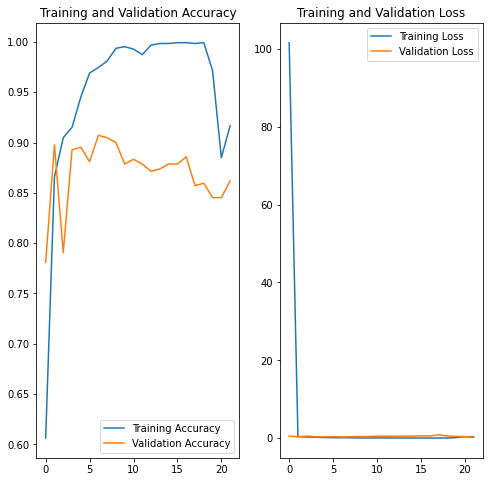

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()